In [ ]:
!pip install mediapipe==0.10.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving ground_truth.txt to ground_truth.txt
Video FPS: 29.548271
Extracted 1801 frames.
Computed 137 BP windows.
Window 000: Systolic = 131.64, Diastolic = 71.89
Window 001: Systolic = 127.38, Diastolic = 81.54
Window 002: Systolic = 123.09, Diastolic = 73.27
Window 003: Systolic = 140.72, Diastolic = 76.27
Window 004: Systolic = 117.07, Diastolic = 73.42
Window 005: Systolic = 143.83, Diastolic = 77.74
Window 006: Systolic = 135.84, Diastolic = 73.84
Window 007: Systolic = 133.54, Diastolic = 73.31
Window 008: Systolic = 140.95, Diastolic = 70.22
Window 009: Systolic = 121.86, Diastolic = 69.88
Window 010: Systolic = 139.71, Diastolic = 71.61
Window 011: Systolic = 129.19, Diastolic = 65.03
Window 012: Systolic = 132.20, Diastolic = 76.46
Window 013: Systolic = 119.72, Diastolic = 66.67
Window 014: Systolic = 137.48, Diastolic = 78.87
Window 015: Systolic = 120.83, Diastolic = 72.08
Window 016: Systolic = 133.64, Diastolic = 71.11
Window 017: Systolic = 110.81, Diastolic = 78.13
Windo

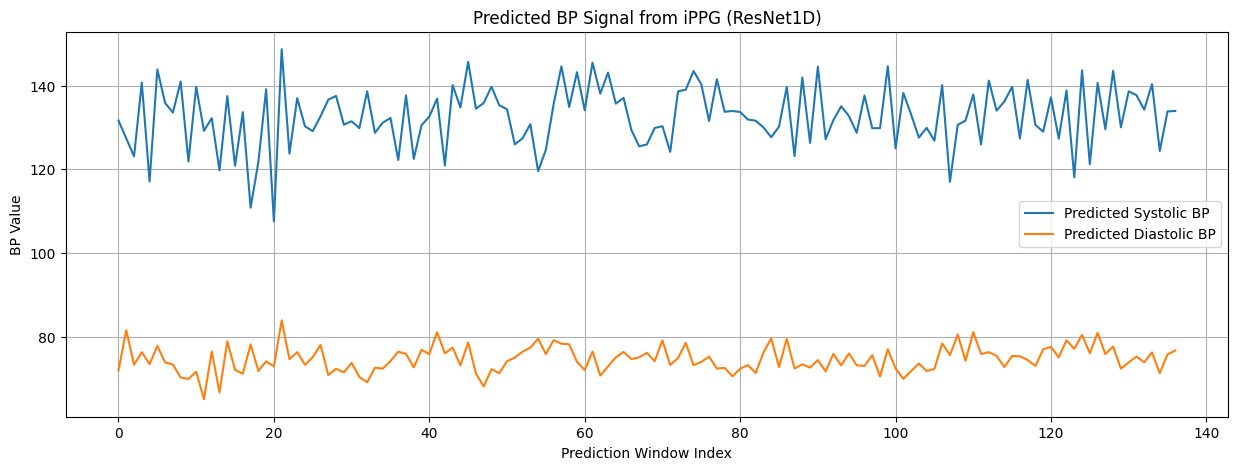

In [1]:
# Import libraries
import cv2
import numpy as np
import mediapipe as mp
from scipy.signal import butter, filtfilt, detrend
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from google.colab import files

# Upload ground truth (optional)
uploaded = files.upload()
gt_path = next(iter(uploaded))

# Paths
video_path = '/content/drive/MyDrive/3video.avi'
model_path = '/content/drive/MyDrive/1-D_Resnet_val_3.66_10k.pth'  # Your model

# Face Mesh setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Functions
def bandpass_filter(signal, fs, low=0.7, high=3.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, signal)

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

def get_face_mask(landmarks, img_shape):
    face_idx = list(range(468))
    h, w = img_shape
    points = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in face_idx])
    hull = cv2.convexHull(points)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillConvexPoly(mask, hull, 255)
    return mask

# Define Residual Block 1D
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

# Define full ResNet1D
class ResNet1D(nn.Module):
    def __init__(self, in_channels, num_classes=2):
        super(ResNet1D, self).__init__()
        self.layer0 = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(64, 64, blocks=2)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        layers = [ResidualBlock1D(in_channels, out_channels, stride, downsample)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# Step 1: Extract iPPG from video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
print(f"Video FPS: {fps}")

signals = []
timestamps = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    ts = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = face_mesh.process(img_rgb)
    if not res.multi_face_landmarks:
        continue
    landmarks = res.multi_face_landmarks[0].landmark
    mask = get_face_mask(landmarks, frame.shape[:2])

    green = frame[:, :, 1]
    skin_pixels = green[mask > 0]

    if skin_pixels.size == 0:
        continue

    green_mean = np.mean(skin_pixels)
    signals.append(green_mean)
    timestamps.append(ts)

cap.release()

signals = np.array(signals)
timestamps = np.array(timestamps)
print(f"Extracted {len(signals)} frames.")

# Preprocessing
signals_detrended = detrend(signals)
signals_filtered = bandpass_filter(signals_detrended, fps)
ppg_signal = normalize_signal(signals_filtered)

# Step 2: Load ResNet1D model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet1D(in_channels=1, num_classes=2).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Step 3: Predict BP (using sliding window)
window_size = 437
step_size = 10

predictions = []

for start in range(0, len(ppg_signal) - window_size, step_size):
    segment = ppg_signal[start:start + window_size]
    segment = torch.tensor(segment, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # shape (1, 1, 437)
    with torch.no_grad():
        pred = model(segment)
    predictions.append(pred.cpu().numpy().flatten())  # shape (2,)

predictions = np.array(predictions)
print(f"Computed {len(predictions)} BP windows.")

# ---- New: print each window's systolic & diastolic ----
for i, (sys, dia) in enumerate(predictions):
    print(f"Window {i:03d}: Systolic = {sys:.2f}, Diastolic = {dia:.2f}")

# ---- And print overall average BP ----
mean_sys = predictions[:,0].mean()
mean_dia = predictions[:,1].mean()
print(f"\nAverage Predicted → Systolic: {mean_sys:.2f}, Diastolic: {mean_dia:.2f}")

# Step 4: Plot BP
plt.figure(figsize=(15, 5))
plt.plot(predictions[:, 0], label='Predicted Systolic BP')
plt.plot(predictions[:, 1], label='Predicted Diastolic BP')
plt.legend()
plt.title('Predicted BP Signal from iPPG (ResNet1D)')
plt.xlabel('Prediction Window Index')
plt.ylabel('BP Value')
plt.grid()
plt.show()


In [15]:
# Install dependencies
!pip install gradio torch torchvision scipy

import cv2
import numpy as np
import mediapipe as mp
from scipy.signal import butter, filtfilt, detrend
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gradio as gr

# --- Helper functions ---
def bandpass_filter(signal, fs, low=0.7, high=3.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, signal)

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

def get_face_mask(landmarks, img_shape):
    idx = list(range(468))
    h, w = img_shape
    pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in idx])
    hull = cv2.convexHull(pts)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillConvexPoly(mask, hull, 255)
    return mask

# --- Model Definition ---
class ResidualBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, 3, stride, 1)
        self.bn1   = nn.BatchNorm1d(out_ch)
        self.conv2 = nn.Conv1d(out_ch, out_ch, 3, 1, 1)
        self.bn2   = nn.BatchNorm1d(out_ch)
        self.relu  = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        id = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            id = self.downsample(x)
        return self.relu(out + id)

class ResNet1D(nn.Module):
    def __init__(self, in_ch, num_classes=2):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv1d(in_ch, 64, 7, 2, 3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(3, 2, 1)
        )
        self.layer1 = self._make_layer(64,  64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128,256, 2, stride=2)
        self.layer4 = self._make_layer(256,512, 2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_ch, out_ch, blocks, stride=1):
        down = None
        if stride != 1 or in_ch != out_ch:
            down = nn.Sequential(
                nn.Conv1d(in_ch, out_ch, 1, stride),
                nn.BatchNorm1d(out_ch)
            )
        layers = [ResidualBlock1D(in_ch, out_ch, stride, down)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_ch, out_ch))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# --- Inference and Plot ---
def analyze_video(video_file):
    # Face mesh
    fm = mp.solutions.face_mesh.FaceMesh(
        static_image_mode=False, max_num_faces=1,
        refine_landmarks=True, min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )

    # Read video
    cap = cv2.VideoCapture(video_file.name)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    sigs = []
    while True:
        ret, frame = cap.read()
        if not ret: break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = fm.process(rgb)
        if not res.multi_face_landmarks: continue
        lm = res.multi_face_landmarks[0].landmark
        mask = get_face_mask(lm, frame.shape[:2])
        skin = frame[:,:,1][mask>0]
        if skin.size: sigs.append(np.mean(skin))
    cap.release()

    # Fixed bandpass range
    data = normalize_signal(bandpass_filter(detrend(np.array(sigs)), fps, low=0.7, high=3.0))

    # Load model
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mdl = ResNet1D(1,2).to(dev)
    mdl.load_state_dict(torch.load(model_path, map_location=dev))
    mdl.eval()

    # Sliding windows
    preds = []
    w, st = 437, 10
    for i in range(0, len(data)-w, st):
        seg = torch.tensor(data[i:i+w], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(dev)
        with torch.no_grad(): out = mdl(seg).cpu().numpy().flatten()
        preds.append(out)
    preds = np.vstack(preds)
    avg_sys, avg_dia = preds[:,0].mean(), preds[:,1].mean()

    # Plot
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(preds[:,0], label='Systolic')
    ax.plot(preds[:,1], label='Diastolic')
    ax.set_title('Predicted BP over Time')
    ax.legend()
    ax.set_xlabel('Window Index')
    ax.set_ylabel('BP')
    plt.tight_layout()

    return f"Average Systolic: {avg_sys:.2f}, Diastolic: {avg_dia:.2f}", fig

# --- Gradio Interface ---
iface = gr.Interface(
    fn=analyze_video,
    inputs=gr.File(label="Upload a Video File"),  # File upload for video
    outputs=[
        gr.Textbox(label='Average Predicted Blood Pressure'),
        gr.Plot(label='BP Prediction Time Series')
    ],
    title='rPPG-based BP Prediction'  # Updated title
)

# Launch for Colab without opening a browser
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://87c77536c203f5502f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
